In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize, curve_fit
from iminuit import Minuit

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

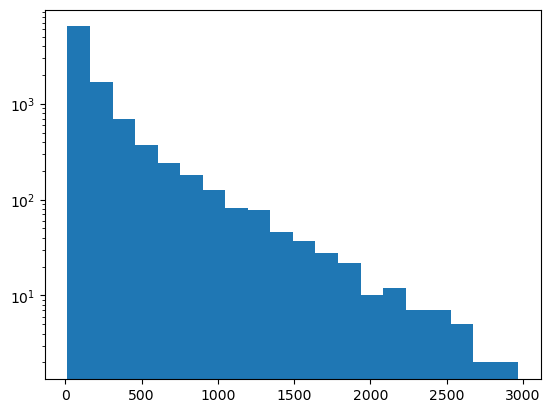

,energy,cosdec,events
0,10.0,0.000000,2004
1,10.0,0.010101,1905
2,10.0,0.020202,1831
3,10.0,0.030303,1776
4,10.0,0.040404,1714
...,...,...,...
9995,100.0,0.959596,26
9996,100.0,0.969697,23
9997,100.0,0.979798,18
9998,100.0,0.989899,25


In [38]:
def atmo_event_rate(energy, cos_theta, sin2theta=0.9, dm2=2.4e-3):
    flux = 1e5*energy**-1.7 # the true neutrino flux is steeper, this takes into account 
                            # neutrino cross-section, which is proportional to E
                            # as well as that we are working with logarithmic energy bins    
    l = 12e3 * cos_theta # base line - max corresponds to diameter of the Earth 12e3 km

    # two flavor oscillation propability for muon disappearance - see wikipedia 
    osc_prop = 1-sin2theta * np.sin(1.27*dm2*l/energy) 

    return flux*osc_prop

def run_experiment(energy, cosdec, sin2theta=0.9, dm2=2.4e-3):
    x = np.array(energy.size)
    events=np.zeros(energy.size*cosdec.size)
    rows = []
    i = 0
    for e in energy:
        for c in cosdec:
            mu = atmo_event_rate(e,c,sin2theta,dm2)
            sig = np.sqrt(mu)
            event_random = np.random.normal(mu,sig)
            events[i] = int(event_random) 
            i=i+1
            rows.append([e,c,int(event_random)])
    events_df = pd.DataFrame(rows, columns=['energy','cosdec','events'])
    return events_df

def generate_data(N, sin2theta=0.9, dm2=2.4e-3):
    
    cosdec =  np.linspace(0, 1, N) # N steps in cos(declination) from 0 to 1 
    energy = 10**np.linspace(1, 2, N) # N steps in log10(energy) from 10 to 100 GeV
    
    events_df = run_experiment(energy,cosdec,sin2theta,dm2)
    
    return events_df

events_df = generate_data(100)

plt.hist(events_df["events"], bins=20)
plt.yscale('log')

plt.show() 
events_df

In [87]:
events_df = generate_data(100, sin2theta=0.9, dm2=2.4e-3)

def chi2(sin2theta, dm2):

    energy, cosdec, events = events_df["energy"], events_df["cosdec"], events_df["events"]
    model_events = atmo_event_rate(energy, cosdec, sin2theta, dm2)
    chi2 = np.sum((events - model_events)**2 / model_events)
    return chi2

chi2(0.9, 2.4e-3)

9757.790766503978

In [88]:
m = Minuit(chi2, sin2theta=0.9, dm2=2.4e-3)
print(m.migrad())
print(m.fval)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 9755                       │              Nfcn = 29               │
│ EDM = 5.32e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─

In [92]:
N_sim = 500
chi2_vals =[]
for sim in range(N_sim):
    events_df = generate_data(100, sin2theta=0.9, dm2=2.4e-3)
    
    def chi2(sin2theta, dm2):

        energy, cosdec, events = events_df["energy"], events_df["cosdec"], events_df["events"]
        model_events = atmo_event_rate(energy, cosdec, sin2theta, dm2)
        chi2 = np.sum((events - model_events)**2 / model_events)
        return chi2
    
    m = Minuit(chi2, sin2theta=0.9, dm2=2.4e-3)
    m.migrad()
    chi2_vals.append(m.fval)



(array([11.,  9., 10., 23., 32., 42., 50., 46., 58., 56., 49., 27., 37.,
        21., 12.,  7.,  5.,  4.,  0.,  1.]),
 array([ 9702.12563848,  9741.85901842,  9781.59239836,  9821.3257783 ,
         9861.05915823,  9900.79253817,  9940.52591811,  9980.25929805,
        10019.99267799, 10059.72605793, 10099.45943787, 10139.19281781,
        10178.92619775, 10218.65957769, 10258.39295762, 10298.12633756,
        10337.8597175 , 10377.59309744, 10417.32647738, 10457.05985732,
        10496.79323726]),
 <BarContainer object of 20 artists>)

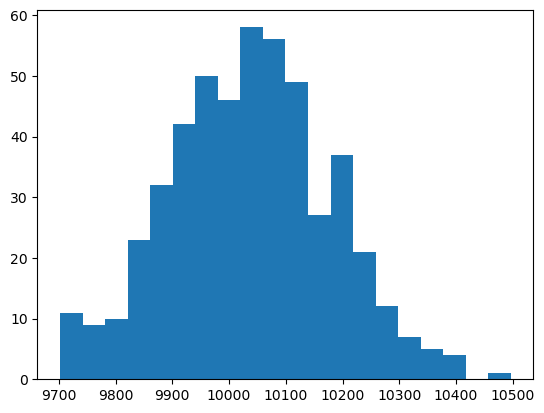

In [93]:
plt.hist(chi2_vals, bins=20)